In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

from keras import backend as K
from keras.models import Model

import mnist_epistemic_dense as mp
import mnist_epistemic_dense_blurred as bl
import combined_uncertainty as cu
import combined_uncertainty_blurred as cubl
import aleatoric_uncertainty as au
import aleatoric_uncertainty_blurred as aubl

Using TensorFlow backend.


## Epistemic Uncertainty

### - Missing pixel

In [2]:
#create the output image directory
if (os.path.isdir('images')==0):
    os.mkdir('images')

#choose dataset
dataset_name = 'mnist'#

#create AE model
architecture = 'mlp' #'convolutional'
ae_mp = mp.autoencoder(dataset_name,architecture)

ae_mp.ae.load_weights("./models/dense_deep_ae_mse.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/clement/anaconda3/envs/tf1-gpu/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                3084

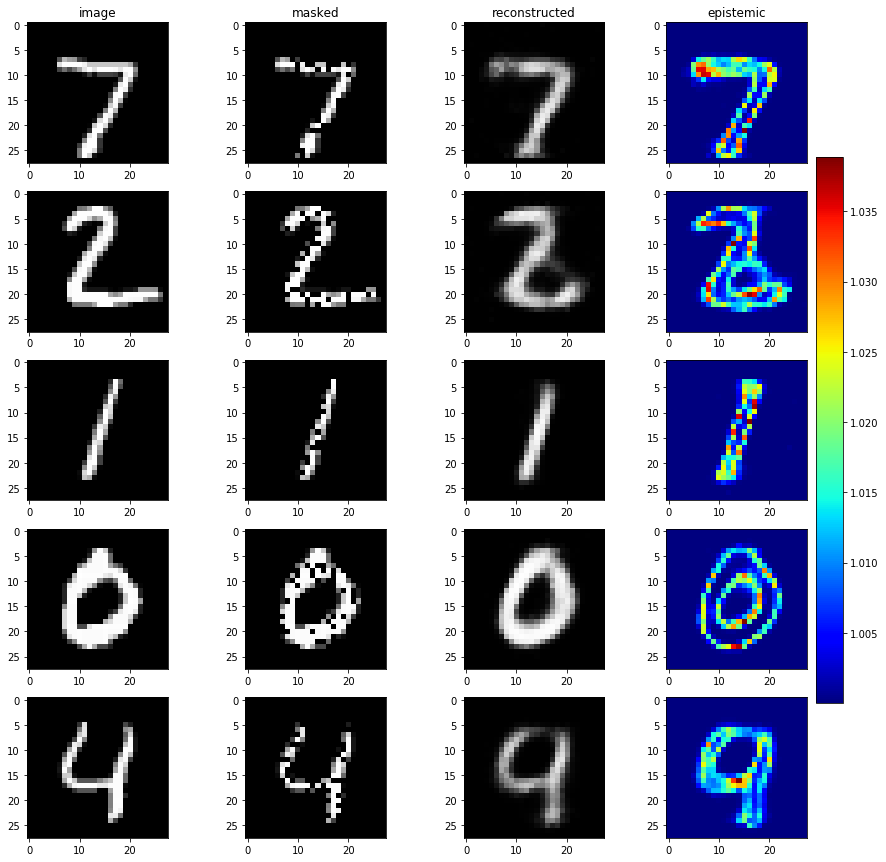

In [3]:
ae_mp.test()

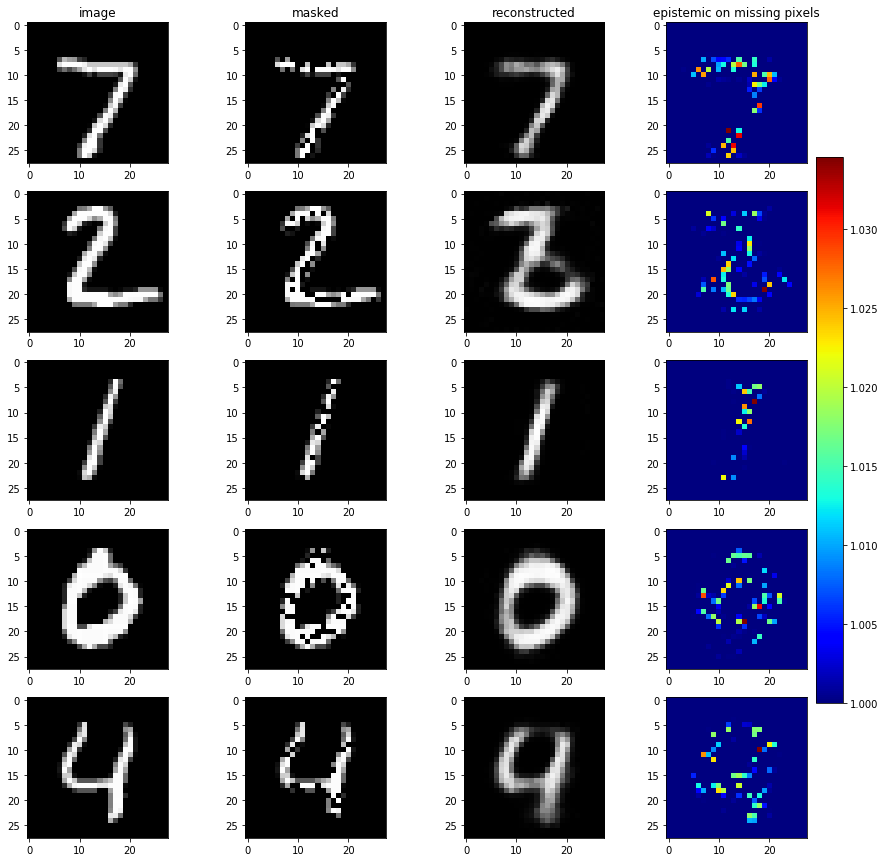

In [4]:
ae_mp.test_MP()

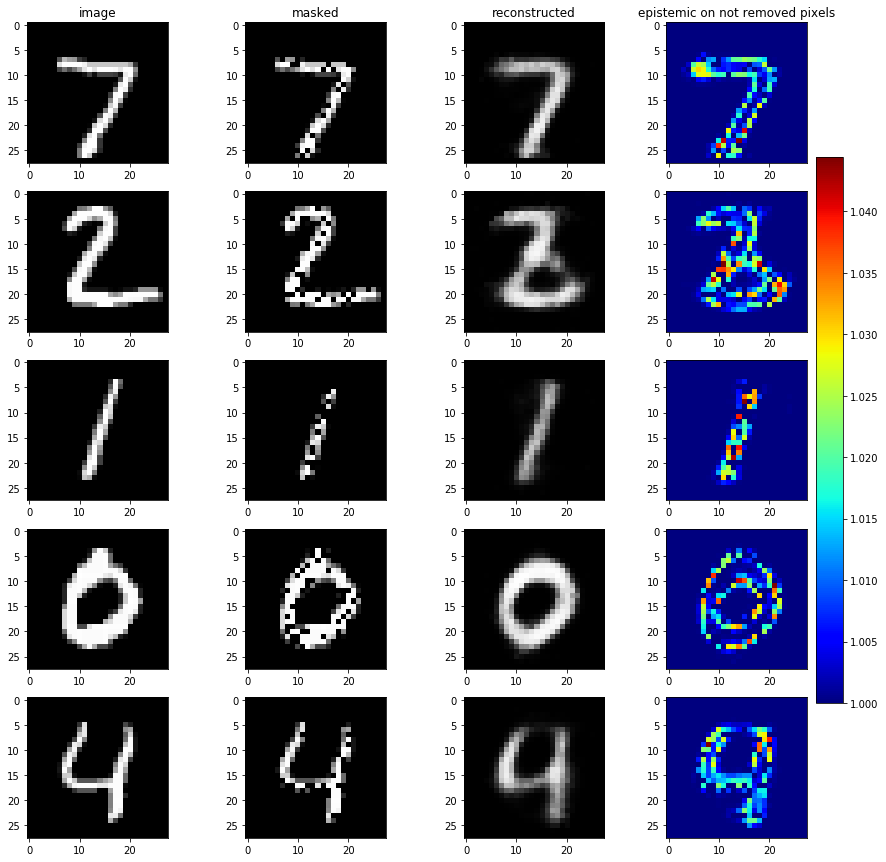

In [5]:
ae_mp.test_MP2()

Comme c'est un autoencodeur, finalement, il reconstruit toute l'image. Ce n'est donc pas anormal qu'il y ait aussi de l'incertitude sur les pixels non manquants.

In [6]:
X_train,X_test = ae_mp.load_data("mnist")

In [7]:
img = X_test[0].reshape((28,28))
masked_img = img*np.random.binomial(1,0.75,size=img.shape)
output_img = ae_mp.ae.predict(masked_img.reshape(1,28,28,1)).reshape(28,28)

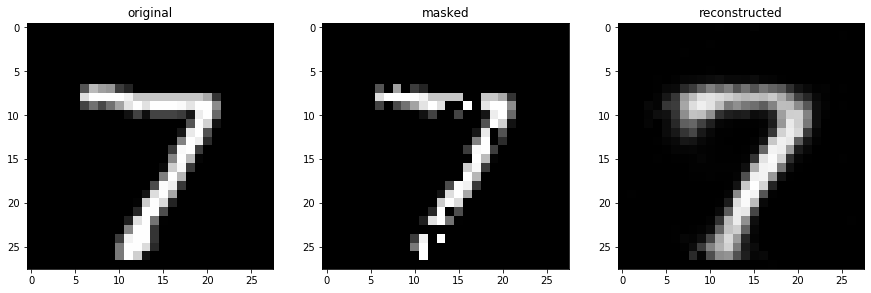

In [8]:
fig,axes = plt.subplots(1,3,figsize=(15,15))
axes[0].imshow(img,"gray")
axes[0].set_title("original")
axes[1].imshow(masked_img,"gray")
axes[1].set_title("masked")
axes[2].imshow(output_img,"gray")
axes[2].set_title("reconstructed")
plt.show()

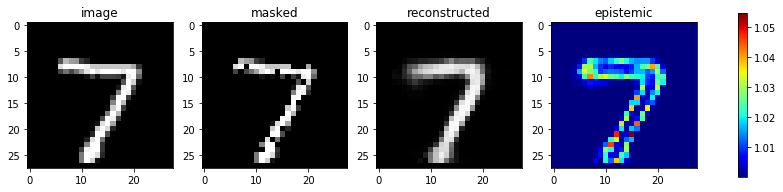

In [9]:
ae_mp.test(1)

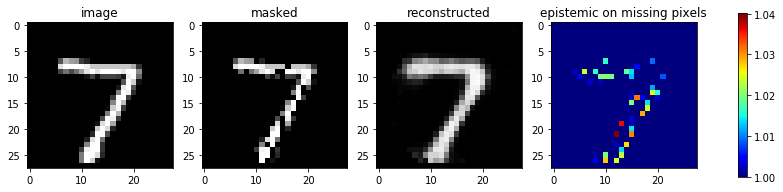

In [10]:
ae_mp.test_MP(1)

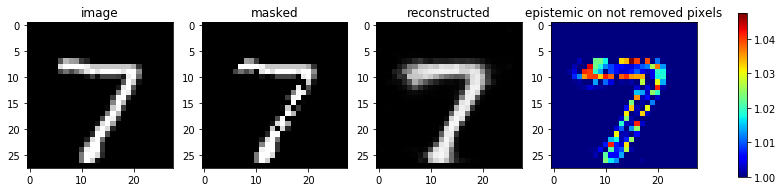

In [11]:
ae_mp.test_MP2(1)

 ### - Blurred Images

In [12]:
ae_bl = bl.autoencoder(dataset_name,architecture)

# ae.ae.load_weights('dense_deep_ae.h5')
ae_bl.ae.load_weights("./models/dense_mse_blurred.h5")

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                3084

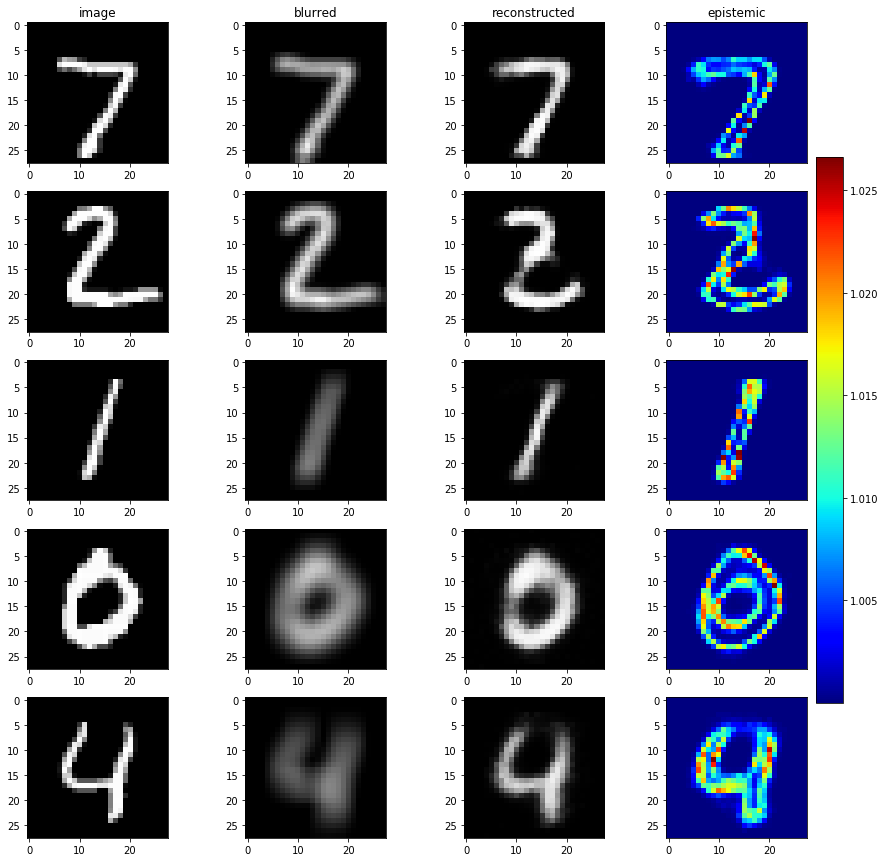

In [13]:
ae_bl.test()

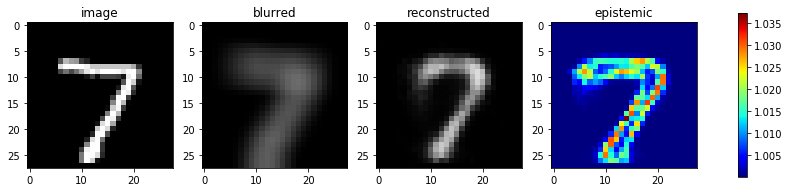

In [14]:
ae_bl.test(1)

#### Precision Recall

In [15]:
def rmsd(imgs,prbl,ae,MP=False):
    if prbl == "pixels":
        mask = np.random.binomial(1,0.75,size=imgs.shape)
        outputs = ae.ae.predict(imgs*mask)
        if MP:
            missingPixels = (imgs-outputs)*(1-mask)
            nonMissingPixels = (imgs-outputs)*mask
            rmsdMP = K.sqrt(K.mean(K.square(missingPixels.reshape(-1,28*28)),axis=-1))
            rmsdNMP = K.sqrt(K.mean(K.square(nonMissingPixels.reshape(-1,28*28)),axis=-1))
            return K.eval(rmsdMP),K.eval(rmsdNMP)
            
    elif prbl=="deblur":
        n_img = len(imgs)
        curr_batch_blurred = np.zeros(imgs.shape)
        for ind,img in enumerate(imgs):
            curr_batch_blurred[ind] = bl.image_blur(img).reshape(28,28,1)
        outputs = ae.ae.predict(curr_batch_blurred.reshape(n_img,28,28,1))
        
    rmsd = K.sqrt(K.mean(K.square((imgs-outputs).reshape(-1,28*28)),axis=-1))
    return K.eval(rmsd)

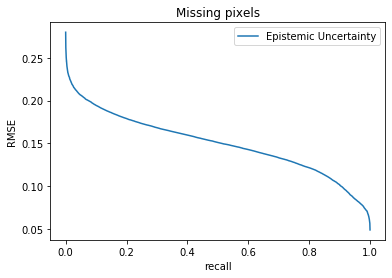

In [16]:
errors = rmsd(X_test,"pixels",ae_mp)
errors.sort()
plt.plot([(k+1)/len(errors) for k in range(len(errors))],errors[::-1],label="Epistemic Uncertainty")
plt.xlabel("recall")
plt.ylabel("RMSE")
plt.title("Missing pixels")
plt.legend()
plt.show()

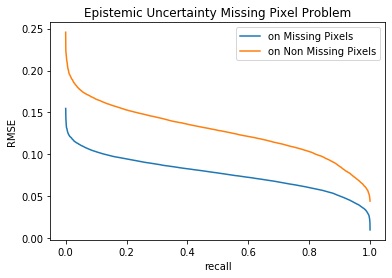

In [17]:
errorsMP,errorsNMP = rmsd(X_test,"pixels",ae_mp,MP=True)
errorsMP.sort()
errorsNMP.sort()
plt.plot([(k+1)/len(errorsMP) for k in range(len(errorsMP))],errorsMP[::-1],label="on Missing Pixels")
plt.plot([(k+1)/len(errorsNMP) for k in range(len(errorsNMP))],errorsNMP[::-1],label="on Non Missing Pixels")
plt.xlabel("recall")
plt.ylabel("RMSE")
plt.title("Epistemic Uncertainty Missing Pixel Problem")
plt.legend()
plt.show()

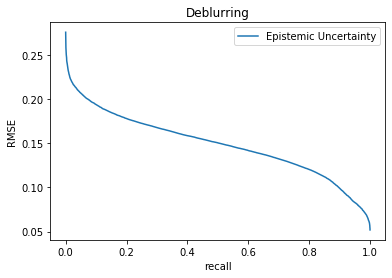

In [18]:
errors = rmsd(X_test,"deblur",ae_bl)
errors.sort()
plt.plot([(k+1)/len(errors) for k in range(len(errors))],errors[::-1],label="Epistemic Uncertainty")
plt.xlabel("recall")
plt.ylabel("RMSE")
plt.title("Deblurring")
plt.legend()
plt.show()

## Aleatoric Uncertainty

### - Missing Pixels

In [21]:
ae_aump = au.autoencoder(dataset_name,architecture)

ae_aump.ae.load_weights("./models/dense_aleatoric_mse.h5")

/home/clement/anaconda3/envs/tf1-gpu/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 12)                3084      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               3328      
_________________________________________________________________
dense_18 (Dense)             (None, 512)               1315

In [22]:
noiseModel = Model(inputs=ae_aump.ae.input,outputs=ae_aump.model_out.get_layer("noise").output)

In [23]:
img = X_test*np.random.binomial(1,0.75,size=X_test.shape)
noise = noiseModel.predict(img)

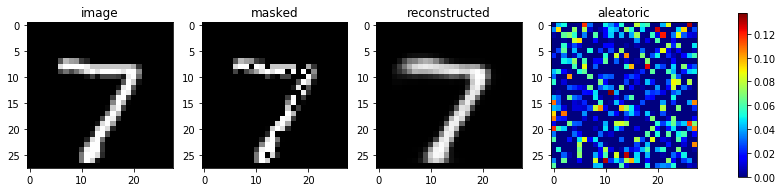

In [24]:
fig,ax = plt.subplots(1,4,figsize=(15,15))
ax[0].imshow(X_test[0].reshape(28,28),"gray")
ax[0].set_title("image")
ax[1].imshow(img[0].reshape(28,28),"gray")
ax[1].set_title("masked")
ax[2].imshow(ae_aump.ae.predict(img)[0].reshape(28,28),"gray")
ax[2].set_title("reconstructed")
cb = ax[3].imshow(noise[0].reshape(28,28),"jet")
ax[3].set_title("aleatoric")
fig.colorbar(cb,ax=ax,shrink=0.2,location="right")
plt.show()

### - Blurred Images

In [25]:
ae_aubl = aubl.autoencoder(dataset_name,architecture)

ae_aubl.ae.load_weights("./models/dense_aleatoric_mse_blurred.h5")

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 12)                3084      
_________________________________________________________________
dense_24 (Dense)             (None, 256)               3328      
_________________________________________________________________
dense_26 (Dense)             (None, 512)               1315

In [26]:
noiseModel = Model(inputs=ae_aubl.ae.input,outputs=ae_aubl.model_out.get_layer("noise").output)

In [27]:
img = aubl.image_blur(X_test[0]).reshape(1,28,28,1)
noise = noiseModel.predict(img)

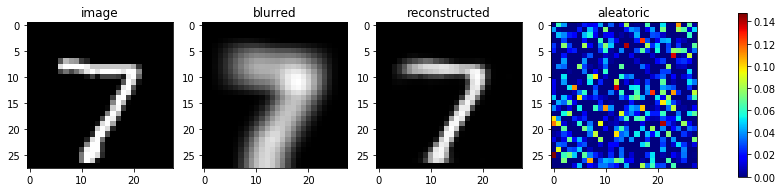

In [28]:
fig,ax = plt.subplots(1,4,figsize=(15,15))
ax[0].imshow(X_test[0].reshape(28,28),"gray")
ax[0].set_title("image")
ax[1].imshow(img[0].reshape(28,28),"gray")
ax[1].set_title("blurred")
ax[2].imshow(ae_aubl.ae.predict(img).reshape(28,28),"gray")
ax[2].set_title("reconstructed")
cb = ax[3].imshow(noise[0].reshape(28,28),"jet")
ax[3].set_title("aleatoric")            
fig.colorbar(cb,ax=ax,shrink=0.2,location="right")
plt.show()

#### Precision Recall

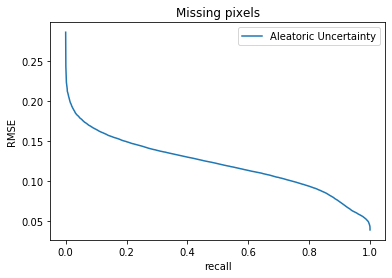

In [29]:
errors = rmsd(X_test,"pixels",ae_aump)
errors.sort()
plt.plot([(k+1)/len(errors) for k in range(len(errors))],errors[::-1],label="Aleatoric Uncertainty")
plt.xlabel("recall")
plt.ylabel("RMSE")
plt.title("Missing pixels")
plt.legend()
plt.show()

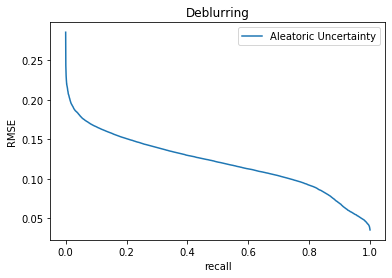

In [30]:
errors = rmsd(X_test,"deblur",ae_aubl)
errors.sort()
plt.plot([(k+1)/len(errors) for k in range(len(errors))],errors[::-1],label="Aleatoric Uncertainty")
plt.xlabel("recall")
plt.ylabel("RMSE")
plt.title("Deblurring")
plt.legend()
plt.show()

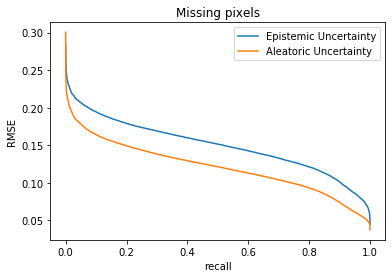

In [31]:
errors1 = rmsd(X_test,"pixels",ae_mp)
errors1.sort()
plt.plot([(k+1)/len(errors1) for k in range(len(errors1))],errors1[::-1],label="Epistemic Uncertainty")
errors2 = rmsd(X_test,"pixels",ae_aump)
errors2.sort()
plt.plot([(k+1)/len(errors2) for k in range(len(errors2))],errors2[::-1],label="Aleatoric Uncertainty")
plt.xlabel("recall")
plt.ylabel("RMSE")
plt.title("Missing pixels")
plt.legend()
plt.show()

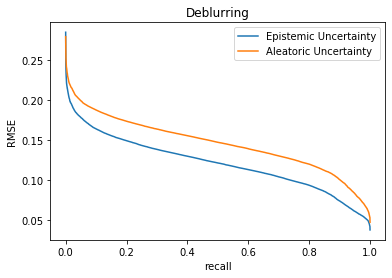

In [32]:
errors1 = rmsd(X_test,"pixels",ae_aump)
errors1.sort()
plt.plot([(k+1)/len(errors1) for k in range(len(errors1))],errors1[::-1],label="Epistemic Uncertainty")
errors2 = rmsd(X_test,"pixels",ae_aubl)
errors2.sort()
plt.plot([(k+1)/len(errors2) for k in range(len(errors2))],errors2[::-1],label="Aleatoric Uncertainty")
plt.xlabel("recall")
plt.ylabel("RMSE")
plt.title("Deblurring")
plt.legend()
plt.show()

## Combined Uncertainty

### - Missing Pixels

In [33]:
ae_cump = cu.autoencoder(dataset_name,architecture)

ae_cump.ae.load_weights("./models/dense_combined.h5")

/home/clement/anaconda3/envs/tf1-gpu/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 12)                3084

#### Combined Uncertainty

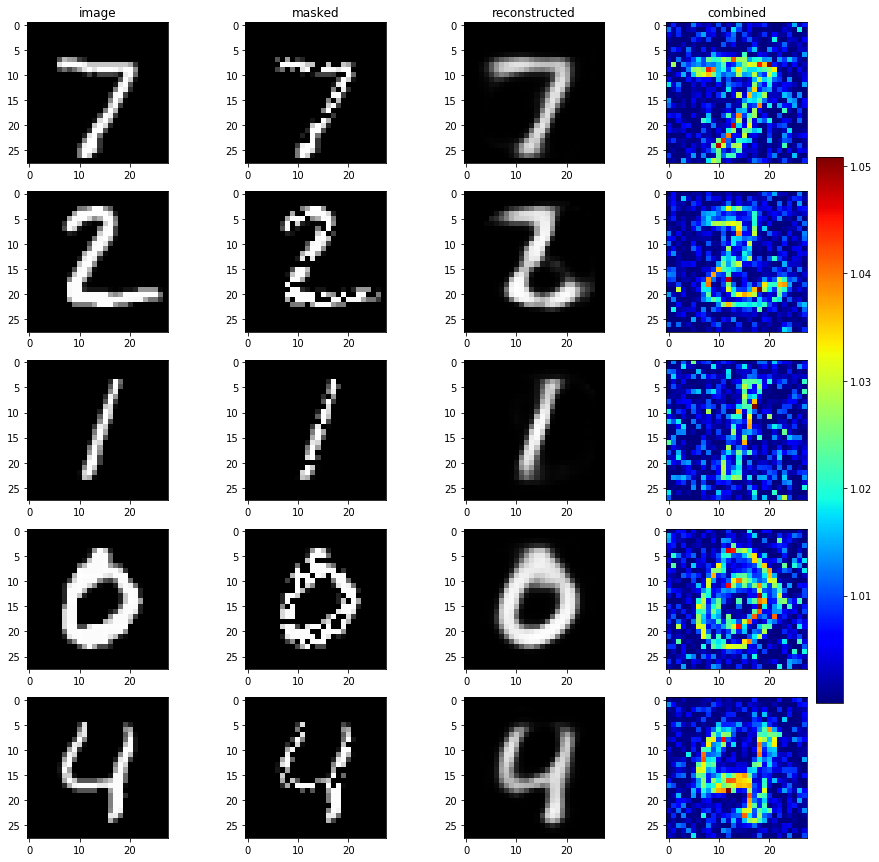

In [34]:
ae_cump.test(5)

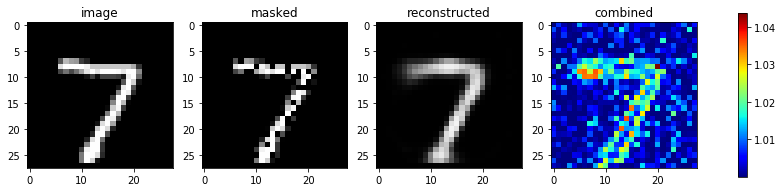

In [35]:
ae_cump.test(1)

#### Aleatoric Uncertainty

In [36]:
noiseModel = Model(inputs=ae_cump.ae.input,outputs=ae_cump.model_out.get_layer("noise").output)

In [37]:
img = X_test*np.random.binomial(1,0.75,size=X_test.shape)
noise = noiseModel.predict(X_test)

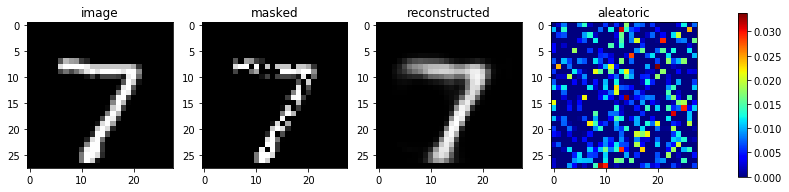

In [38]:
fig,ax = plt.subplots(1,4,figsize=(15,15))
ax[0].imshow(X_test[0].reshape(28,28),"gray")
ax[0].set_title("image")
ax[1].imshow(img[0].reshape(28,28),"gray")
ax[1].set_title("masked")
ax[2].imshow(ae_cump.ae.predict(img)[0].reshape(28,28),"gray")
ax[2].set_title("reconstructed")
cb = ax[3].imshow(noise[0].reshape(28,28),"jet")
ax[3].set_title("aleatoric")
fig.colorbar(cb,ax=ax,shrink=0.2,location="right")
plt.show()

### - Blurred Images

In [39]:
ae_cubl = cubl.autoencoder(dataset_name,architecture)

ae_cubl.ae.load_weights("./models/dense_combined_blurred.h5")

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 12)                308

#### Combined Uncertainty

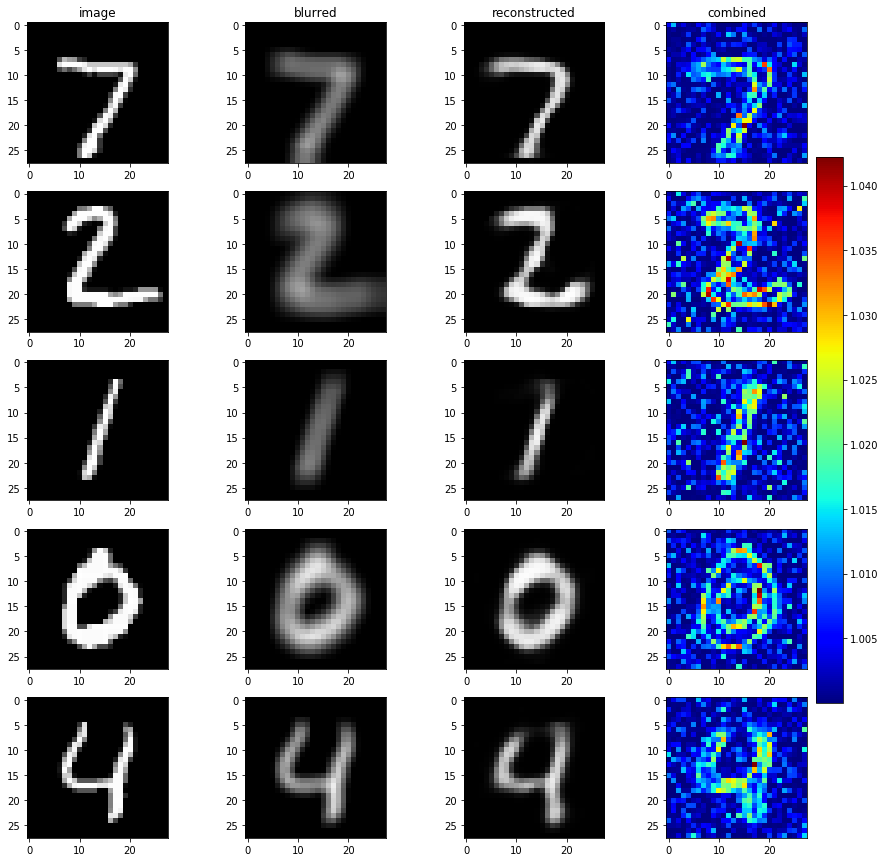

In [40]:
ae_cubl.test(5)

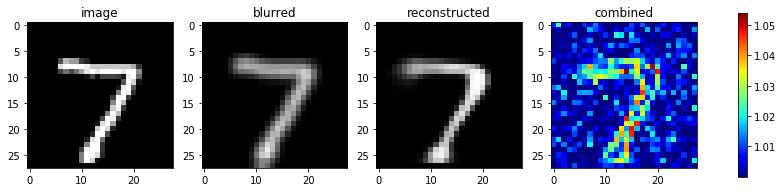

In [41]:
ae_cubl.test(1)

#### Aleatoric Uncertainty

In [42]:
noiseModel = Model(inputs=ae_cubl.ae.input,outputs=ae_cubl.model_out.get_layer("noise").output)

In [43]:
img = aubl.image_blur(X_test[0]).reshape(1,28,28,1)
noise = noiseModel.predict(img)

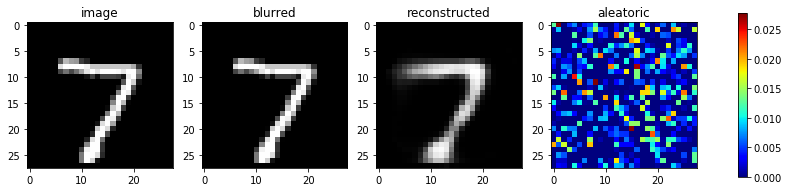

In [44]:
fig,ax = plt.subplots(1,4,figsize=(15,15))
ax[0].imshow(X_test[0].reshape(28,28),"gray")
ax[0].set_title("image")
ax[1].imshow(img.reshape(28,28),"gray")
ax[1].set_title("blurred")
ax[2].imshow(ae_cubl.ae.predict(img).reshape(28,28),"gray")
ax[2].set_title("reconstructed")
cb = ax[3].imshow(noise[0].reshape(28,28),"jet")
ax[3].set_title("aleatoric")
fig.colorbar(cb,ax=ax,shrink=0.2,location="right")
plt.show()